# Music Genre Classification

In this notebook, we use the MusicCaps text database to classify descriptions of music clips by music genre, as labelled by the AudioSet dataset.

To start, we will import our packages below. We will mainly be using `nltk` and `sklearn` to process our data.

In [46]:
# !pip install -q nltk
!pip install -q scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()
import pandas as pd
import nltk

from sklearn.cluster import KMeans
import numpy as np
import os
from string import punctuation

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [47]:
os.path.abspath("musiccaps-public.csv")

'/home/ajb46717/workDir/projects/music_caps/musiccaps-public.csv'

In [48]:
#load dataframe
data = pd.read_csv('./data/musiccaps-public.csv') #path/to/musiccaps dataset
caps_df = pd.DataFrame(data, columns=['aspect_list', 'audioset_positive_labels', 'caption', 'is_balanced_subset'])
pd.set_option('display.max_colwidth', None)
caps_df.head()

,aspect_list,audioset_positive_labels,caption,is_balanced_subset
0,"['low quality', 'sustained strings melody', 'soft female vocal', 'mellow piano melody', 'sad', 'soulful', 'ballad']","/m/0140xf,/m/02cjck,/m/04rlf","The low quality recording features a ballad song that contains sustained strings, mellow piano melody and soft female vocal singing over it. It sounds sad and soulful, like something you would hear at Sunday services.",False
1,"['guitar song', 'piano backing', 'simple percussion', 'relaxing melody', 'slow tempo', 'bass', 'country feel', 'instrumental', 'no voice']","/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf,/m/04szw,/m/07s0s5r,/m/0fx80y,/m/0gg8l",This song features an electric guitar as the main instrument. The guitar plays a descending run in the beginning then plays an arpeggiated chord followed by a double stop hammer on to a higher note and a descending slide followed by a descending chord run. The percussion plays a simple beat using rim shots. The percussion plays in common time. The bass plays only one note on the first count of each bar. The piano plays backing chords. There are no voices in this song. The mood of this song is relaxing. This song can be played in a coffee shop.,False
2,"['amateur recording', 'finger snipping', 'male mid range voice singing', 'reverb']","/m/025_jnm,/m/04rlf","a male voice is singing a melody with changing tempos while snipping his fingers rhythmically. The recording sounds like it has been recorded in an empty room. This song may be playing, practicing snipping and singing along.",False
3,"['backing track', 'jazzy', 'digital drums', 'piano', 'e-bass', 'trumpet', 'acoustic guitar', 'digital keyboard song', 'medium tempo']","/m/01g90h,/m/04rlf",This song contains digital drums playing a simple groove along with two guitars. One strumming chords along with the snare the other one playing a melody on top. An e-bass is playing the footnote while a piano is playing a major and minor chord progression. A trumpet is playing a loud melody alongside the guitar. All the instruments sound flat and are being played by a keyboard. There are little bongo hits in the background panned to the left side of the speakers. Apart from the music you can hear eating sounds and a stomach rumbling. This song may be playing for an advertisement.,False
4,"['rubab instrument', 'repetitive melody on different octaves', 'no other instruments', 'plucked string instrument', 'no voice', 'instrumental', 'fast tempo']","/m/02p0sh1,/m/04rlf",This song features a rubber instrument being played. The strumming is fast. The melody is played on one fretted string and other open strings. The melody is played on the lower octave and is later repeated on the higher octave. This song can be played at a folk party.,False


### Converting Labels

We will use the `audioset ontology` from https://github.com/audioset/ontology to convert our genre labels.



In [49]:
#load the ontology for the audioset data
import json
 #path/to/ontology.json from https://github.com/audioset/ontology
with open('./data/ontology/ontology.json') as f:
    ont_dicts = json.load(f)
ont_dicts
for d in ont_dicts:
    d['name'] = d['name'].lower()
ont_dicts

[{'id': '/m/0dgw9r',
  'name': 'human sounds',
  'description': 'Sounds produced by the human body through the actions of the individual.',
  'citation_uri': '',
  'positive_examples': [],
  'child_ids': ['/m/09l8g',
   '/m/01w250',
   '/m/09hlz4',
   '/m/0bpl036',
   '/m/0160x5',
   '/m/0k65p',
   '/m/01jg02',
   '/m/04xp5v',
   '/t/dd00012'],
  'restrictions': ['abstract']},
 {'id': '/m/09l8g',
  'name': 'human voice',
  'description': 'The human voice consists of sound made by a human being using the vocal folds for talking, singing, laughing, crying, screaming, etc. The human voice is specifically a part of human sound production in which the vocal folds are the primary sound source.',
  'citation_uri': 'http://en.wikipedia.org/wiki/Human_voice',
  'positive_examples': [],
  'child_ids': ['/m/09x0r',
   '/m/07p6fty',
   '/m/03qc9zr',
   '/m/02rtxlg',
   '/m/01j3sz',
   '/m/0463cq4',
   '/m/07qw_06',
   '/m/07plz5l',
   '/m/015lz1',
   '/m/02fxyj',
   '/m/07s2xch',
   '/m/07r4k75',


In [50]:
#get genre ids
for dic in ont_dicts:
    if dic['name'] == 'music genre':
        children_ids = [dic['id'] for dic['id'] in dic['child_ids'] ]
        
print (children_ids)

{'id': '/m/0kpv1t', 'name': 'music genre', 'description': 'Portmanteau class holding categories that represent styles or classifications of music, useful in identifying and organizing similar musical artists or recordings.', 'citation_uri': '', 'positive_examples': [], 'child_ids': ['/m/064t9', '/m/0glt670', '/m/06by7', '/m/06j6l', '/m/0gywn', '/m/06cqb', '/m/01lyv', '/m/02x8m', '/m/02w4v', '/m/06j64v', '/m/03_d0', '/m/026z9', '/m/0ggq0m', '/m/02lkt', '/m/0g293', '/m/0155w', '/m/05fw6t', '/m/02v2lh', '/m/0y4f8', '/m/0164x2', '/m/02mscn', '/m/028sqc', '/m/06rqw', '/m/02p0sh1', '/m/05rwpb'], 'restrictions': ['abstract']}
['/m/064t9', '/m/0glt670', '/m/06by7', '/m/06j6l', '/m/0gywn', '/m/06cqb', '/m/01lyv', '/m/02x8m', '/m/02w4v', '/m/06j64v', '/m/03_d0', '/m/026z9', '/m/0ggq0m', '/m/02lkt', '/m/0g293', '/m/0155w', '/m/05fw6t', '/m/02v2lh', '/m/0y4f8', '/m/0164x2', '/m/02mscn', '/m/028sqc', '/m/06rqw', '/m/02p0sh1', '/m/05rwpb']


In [51]:
for dic in ont_dicts:
    if dic['name'] == 'music genre':
        class_labels = [dict_['name'] for dict_ in ont_dicts if dict_['id'] in dic['child_ids'] ]
class_labels.remove('music genre')
class_labels.remove('independent music')
print (class_labels)

['pop music', 'hip hop music', 'rock music', 'rhythm and blues', 'soul music', 'reggae', 'country', 'funk', 'folk music', 'middle eastern music', 'jazz', 'disco', 'classical music', 'electronic music', 'music of latin america', 'blues', 'music for children', 'new-age music', 'vocal music', 'music of africa', 'christian music', 'music of asia', 'ska', 'traditional music']


In [52]:
# remove non-genre labels
for i in range(len(caps_df['audioset_positive_labels'])):
    label = caps_df['audioset_positive_labels'].iloc[i]
    caps_df['audioset_positive_labels'][i] = label.split(',')
    label = label.split(',')
    for id_ in label:
        if id_ not in children_ids: caps_df['audioset_positive_labels'].iloc[i].remove(id_)   
caps_df

/tmp/ipykernel_231075/286483432.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caps_df['audioset_positive_labels'][i] = label.split(',')


,aspect_list,audioset_positive_labels,caption,is_balanced_subset
0,"['low quality', 'sustained strings melody', 'soft female vocal', 'mellow piano melody', 'sad', 'soulful', 'ballad']",[],"The low quality recording features a ballad song that contains sustained strings, mellow piano melody and soft female vocal singing over it. It sounds sad and soulful, like something you would hear at Sunday services.",False
1,"['guitar song', 'piano backing', 'simple percussion', 'relaxing melody', 'slow tempo', 'bass', 'country feel', 'instrumental', 'no voice']","[/m/0155w, /m/01lyv]",This song features an electric guitar as the main instrument. The guitar plays a descending run in the beginning then plays an arpeggiated chord followed by a double stop hammer on to a higher note and a descending slide followed by a descending chord run. The percussion plays a simple beat using rim shots. The percussion plays in common time. The bass plays only one note on the first count of each bar. The piano plays backing chords. There are no voices in this song. The mood of this song is relaxing. This song can be played in a coffee shop.,False
2,"['amateur recording', 'finger snipping', 'male mid range voice singing', 'reverb']",[],"a male voice is singing a melody with changing tempos while snipping his fingers rhythmically. The recording sounds like it has been recorded in an empty room. This song may be playing, practicing snipping and singing along.",False
3,"['backing track', 'jazzy', 'digital drums', 'piano', 'e-bass', 'trumpet', 'acoustic guitar', 'digital keyboard song', 'medium tempo']",[],This song contains digital drums playing a simple groove along with two guitars. One strumming chords along with the snare the other one playing a melody on top. An e-bass is playing the footnote while a piano is playing a major and minor chord progression. A trumpet is playing a loud melody alongside the guitar. All the instruments sound flat and are being played by a keyboard. There are little bongo hits in the background panned to the left side of the speakers. Apart from the music you can hear eating sounds and a stomach rumbling. This song may be playing for an advertisement.,False
4,"['rubab instrument', 'repetitive melody on different octaves', 'no other instruments', 'plucked string instrument', 'no voice', 'instrumental', 'fast tempo']",[/m/02p0sh1],This song features a rubber instrument being played. The strumming is fast. The melody is played on one fretted string and other open strings. The melody is played on the lower octave and is later repeated on the higher octave. This song can be played at a folk party.,False
...,...,...,...,...
5516,"['amateur recording', 'percussion', 'wooden bongo cajon']",[],This audio contains someone playing a wooden bongo cajon. This is an amateur recording.,False
5517,"['instrumental music', 'arabic music', 'generational heritage', 'arabic culture', 'passionate', 'arabic dance music', 'ancient folk music', 'stringed instruments', 'percussion instruments', 'traditional music', 'medium tempo', 'poor audio quality', 'emotional', 'desert sands', 'persia', 'arabic string band', 'folk music', 'folk musicians']","[/m/02p0sh1, /m/06j64v]",The song is an instrumental. The song is medium tempo with various traditional Arabian stringed instruments playing in harmony along with Arabic percussion instruments. The song is traditional and emotional. The song is an ancient folk song but in poor audio quality.,True
5518,"['instrumental', 'no voice', 'electric guitar', 'distortion effect', 'virtuosity', 'rock genre', 'solo']",[],The rock music is purely instrumental and features an electric guitar with a distortion effect on. The guitarist is playing a lot of notes with virtuosity. This music excerpt would make for a really good electric guitar solo.,True
5519,"['instrumental music', 'gospel music', 'strong bass line', 'christian contemporary music', 'triangle percussions', 'piano accompaniment', 'piano playing chords', 'string bass

### Cleaning labels

to clean the labels, we'll only take the first label from each point of labelled data. I do this because after examining the data, they seemed to be labelled with the most general term first.

In [53]:
#clean labels
international_music = ['music of latin america', 'music of africa', 'music of asia', 'middle eastern music', 'music genre']
new_labels = []
for i in range(len(caps_df['audioset_positive_labels'])):
    label = caps_df['audioset_positive_labels'][i]
    new_lab = []
    new_lab = [dic['name'] for dic in ont_dicts\
               if dic['id'] in label]
    caps_df['audioset_positive_labels'].iloc[i] = new_lab
    
for i, val in enumerate(caps_df['aspect_list']):
    for lab in class_labels:
        if lab in val:
            caps_df['audioset_positive_labels'][i].append(lab)
            
for i, val in enumerate(caps_df['audioset_positive_labels']):
    if len(val)==0 : val.append('?')
#     val = ' '.join(val)
    label = ''
    label = val[1] if len(val) > 1 and val[0] == 'music genre' else val[0]    
    caps_df['audioset_positive_labels'].iloc[i] = label
# # caps_df['audioset_positive_labels'].iloc[i] =' '.join(val)
caps_df

/tmp/ipykernel_231075/3701831333.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caps_df['audioset_positive_labels'].iloc[i] = new_lab
/tmp/ipykernel_231075/3701831333.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caps_df['audioset_positive_labels'].iloc[i] = label


,aspect_list,audioset_positive_labels,caption,is_balanced_subset
0,"['low quality', 'sustained strings melody', 'soft female vocal', 'mellow piano melody', 'sad', 'soulful', 'ballad']",?,"The low quality recording features a ballad song that contains sustained strings, mellow piano melody and soft female vocal singing over it. It sounds sad and soulful, like something you would hear at Sunday services.",False
1,"['guitar song', 'piano backing', 'simple percussion', 'relaxing melody', 'slow tempo', 'bass', 'country feel', 'instrumental', 'no voice']",country,This song features an electric guitar as the main instrument. The guitar plays a descending run in the beginning then plays an arpeggiated chord followed by a double stop hammer on to a higher note and a descending slide followed by a descending chord run. The percussion plays a simple beat using rim shots. The percussion plays in common time. The bass plays only one note on the first count of each bar. The piano plays backing chords. There are no voices in this song. The mood of this song is relaxing. This song can be played in a coffee shop.,False
2,"['amateur recording', 'finger snipping', 'male mid range voice singing', 'reverb']",?,"a male voice is singing a melody with changing tempos while snipping his fingers rhythmically. The recording sounds like it has been recorded in an empty room. This song may be playing, practicing snipping and singing along.",False
3,"['backing track', 'jazzy', 'digital drums', 'piano', 'e-bass', 'trumpet', 'acoustic guitar', 'digital keyboard song', 'medium tempo']",jazz,This song contains digital drums playing a simple groove along with two guitars. One strumming chords along with the snare the other one playing a melody on top. An e-bass is playing the footnote while a piano is playing a major and minor chord progression. A trumpet is playing a loud melody alongside the guitar. All the instruments sound flat and are being played by a keyboard. There are little bongo hits in the background panned to the left side of the speakers. Apart from the music you can hear eating sounds and a stomach rumbling. This song may be playing for an advertisement.,False
4,"['rubab instrument', 'repetitive melody on different octaves', 'no other instruments', 'plucked string instrument', 'no voice', 'instrumental', 'fast tempo']",traditional music,This song features a rubber instrument being played. The strumming is fast. The melody is played on one fretted string and other open strings. The melody is played on the lower octave and is later repeated on the higher octave. This song can be played at a folk party.,False
...,...,...,...,...
5516,"['amateur recording', 'percussion', 'wooden bongo cajon']",?,This audio contains someone playing a wooden bongo cajon. This is an amateur recording.,False
5517,"['instrumental music', 'arabic music', 'generational heritage', 'arabic culture', 'passionate', 'arabic dance music', 'ancient folk music', 'stringed instruments', 'percussion instruments', 'traditional music', 'medium tempo', 'poor audio quality', 'emotional', 'desert sands', 'persia', 'arabic string band', 'folk music', 'folk musicians']",middle eastern music,The song is an instrumental. The song is medium tempo with various traditional Arabian stringed instruments playing in harmony along with Arabic percussion instruments. The song is traditional and emotional. The song is an ancient folk song but in poor audio quality.,True
5518,"['instrumental', 'no voice', 'electric guitar', 'distortion effect', 'virtuosity', 'rock genre', 'solo']",?,The rock music is purely instrumental and features an electric guitar with a distortion effect on. The guitarist is playing a lot of notes with virtuosity. This music excerpt would make for a really good electric guitar solo.,True
5519,"['instrumental music', 'gospel music', 'strong bass line', 'christian contemporary music', 'triangle percussions', 'piano accompaniment', 'piano playing chords', 'string bass line', 'keyboard

In [54]:
caps_df.audioset_positive_labels.unique()

array(['?', 'country', 'jazz', 'traditional music', 'classical music',
       'folk music', 'middle eastern music', 'blues', 'rhythm and blues',
       'vocal music', 'funk', 'new-age music', 'music of latin america',
       'soul music', 'music of asia', 'pop music', 'reggae',
       'electronic music', 'hip hop music', 'rock music', 'ska',
       'christian music', 'disco', 'music for children',
       'music of africa', 'independent music'], dtype=object)

Let's look at how many of each label we have.

In [55]:
caps_df.audioset_positive_labels.value_counts()

?                         2984
electronic music           198
jazz                       183
country                    168
classical music            166
rock music                 152
folk music                 145
funk                       141
pop music                  129
blues                      103
hip hop music               96
reggae                      93
new-age music               91
traditional music           85
soul music                  82
music of latin america      77
disco                       77
christian music             71
vocal music                 70
rhythm and blues            70
middle eastern music        68
independent music           62
ska                         61
music of africa             57
music of asia               51
music for children          41
Name: audioset_positive_labels, dtype: int64

## Collapsing Labels

We have 26 labels here, so we will merge some and get rid of others to try to reduce the complexity of the output. 

### THIS STEP IS IMPORTANT

I used domain knowledge to group the new classes, but there are multiple ways to extend or change this step to create new labels.

In [56]:
#categories:
#    hip hop
#    reggae/ska
#    rock/blues
#    funk/disco
#    R&B/soul
#    international music/traditional music
#    country/folk/traditonal
#    electronic
#    classical
#    jazz
#    pop
# get rid of children music, christian music, vocal music, new age

new_labels = dict.fromkeys(['hip hop music', 'rhythm and blues'], 'hip hop')
new_labels.update(dict.fromkeys(['hythm and blues', 'soul music'], 'r&b/soul'))
new_labels.update(dict.fromkeys(['reggae', 'ska'], 'reggae/ska'))
new_labels.update(dict.fromkeys(['rock music', 'blues'], 'rock/blues'))
new_labels.update(dict.fromkeys(['funk', 'disco'], 'funk/disco'))
new_labels.update(dict.fromkeys(['music of latin america', 'music of africa', 'music of asia', 
                                 'middle eastern music', 'traditional music'], 'international/traditional'))
new_labels.update(dict.fromkeys(['country', 'folk music'], 'country/folk'))

labels_to_remove = ['christian music', 'vocal music', 'music for children', 'new-age music', 'independent music']

for i, val in enumerate(caps_df['audioset_positive_labels']):
    if val in labels_to_remove:
        val ='?'
        caps_df['audioset_positive_labels'].iloc[i] = val


/tmp/ipykernel_231075/4288215446.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caps_df['audioset_positive_labels'].iloc[i] = val


In [57]:
caps_df_labeled = caps_df[caps_df['audioset_positive_labels'] != '?'].copy()
caps_df_labeled

for i, val in enumerate(caps_df_labeled['audioset_positive_labels']):
    if val in new_labels.keys():
        caps_df_labeled['audioset_positive_labels'].iloc[i] = new_labels[val]
caps_df_labeled

/tmp/ipykernel_231075/938566879.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caps_df_labeled['audioset_positive_labels'].iloc[i] = new_labels[val]


,aspect_list,audioset_positive_labels,caption,is_balanced_subset
1,"['guitar song', 'piano backing', 'simple percussion', 'relaxing melody', 'slow tempo', 'bass', 'country feel', 'instrumental', 'no voice']",country/folk,This song features an electric guitar as the main instrument. The guitar plays a descending run in the beginning then plays an arpeggiated chord followed by a double stop hammer on to a higher note and a descending slide followed by a descending chord run. The percussion plays a simple beat using rim shots. The percussion plays in common time. The bass plays only one note on the first count of each bar. The piano plays backing chords. There are no voices in this song. The mood of this song is relaxing. This song can be played in a coffee shop.,False
3,"['backing track', 'jazzy', 'digital drums', 'piano', 'e-bass', 'trumpet', 'acoustic guitar', 'digital keyboard song', 'medium tempo']",jazz,This song contains digital drums playing a simple groove along with two guitars. One strumming chords along with the snare the other one playing a melody on top. An e-bass is playing the footnote while a piano is playing a major and minor chord progression. A trumpet is playing a loud melody alongside the guitar. All the instruments sound flat and are being played by a keyboard. There are little bongo hits in the background panned to the left side of the speakers. Apart from the music you can hear eating sounds and a stomach rumbling. This song may be playing for an advertisement.,False
4,"['rubab instrument', 'repetitive melody on different octaves', 'no other instruments', 'plucked string instrument', 'no voice', 'instrumental', 'fast tempo']",international/traditional,This song features a rubber instrument being played. The strumming is fast. The melody is played on one fretted string and other open strings. The melody is played on the lower octave and is later repeated on the higher octave. This song can be played at a folk party.,False
9,"['solo live direct input acoustic guitar strumming', 'airy suspended open chords', 'low fidelity', 'ambient sounds', 'paper shuffling']",classical music,"low fidelity audio from a live performance featuring a solo direct input acoustic guitar strumming airy, suspended open chords. Also present are occasional ambient sounds, perhaps papers being shuffled.",False
11,"['folk music', 'rubab', 'male voice', 'slow tempo', 'emotional song', 'low quality audio', 'violin', 'accordion']",country/folk,This folk song features a male voice singing the main melody in an emotional mood. This is accompanied by an accordion playing fills in the background. A violin plays a droning melody. There is no percussion in this song. This song can be played at a Central Asian classical concert.,False
...,...,...,...,...
5500,"['k-pop', 'boy band', 'male vocals', 'rap-like singing', 'melodic singing', 'synth bass', 'electronic drums', 'energetic', 'hip', 'urban', 'danceable']",international/traditional,"This is a K-pop music piece performed by a boy band. Initially, a male vocalist is singing in a rap-like manner. Then, it switches to another male vocal that is singing more melodically. The melody is being played by a crisp synth sound. The rhythmic background consists of an energetic electronic drum beat. There is a danceable feel to it. This piece could be playing at Korean nightclubs and dance clubs.",False
5501,"['dancehall', 'reggae', 'dub', 'jamaican', 'male vocal', 'medium-to-high pitch singing', 'keyboard', 'chill', 'vibrant', 'lively']",reggae/ska,"This is a dancehall music piece. There is a male vocalist singing at a medium-to-high pitch with a Jamaican accent. In the background, there is a keyboard playing the main melody. The atmosphere of the piece is vibrant. This piece could be used at beach parties and summer/vacation themed movies or TV shows.",True
5511,"['traditional horn instruments', 'devotional', 'ambient crowd noise', 'instrumental music', 'bad audio quality', 'cymbals crashing', 'percussi

In [58]:
for i, val in enumerate(caps_df['audioset_positive_labels']):
    if val in new_labels.keys():
        caps_df['audioset_positive_labels'].iloc[i] = new_labels[val]
caps_df.head()

/tmp/ipykernel_231075/3110854758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caps_df['audioset_positive_labels'].iloc[i] = new_labels[val]


,aspect_list,audioset_positive_labels,caption,is_balanced_subset
0,"['low quality', 'sustained strings melody', 'soft female vocal', 'mellow piano melody', 'sad', 'soulful', 'ballad']",?,"The low quality recording features a ballad song that contains sustained strings, mellow piano melody and soft female vocal singing over it. It sounds sad and soulful, like something you would hear at Sunday services.",False
1,"['guitar song', 'piano backing', 'simple percussion', 'relaxing melody', 'slow tempo', 'bass', 'country feel', 'instrumental', 'no voice']",country/folk,This song features an electric guitar as the main instrument. The guitar plays a descending run in the beginning then plays an arpeggiated chord followed by a double stop hammer on to a higher note and a descending slide followed by a descending chord run. The percussion plays a simple beat using rim shots. The percussion plays in common time. The bass plays only one note on the first count of each bar. The piano plays backing chords. There are no voices in this song. The mood of this song is relaxing. This song can be played in a coffee shop.,False
2,"['amateur recording', 'finger snipping', 'male mid range voice singing', 'reverb']",?,"a male voice is singing a melody with changing tempos while snipping his fingers rhythmically. The recording sounds like it has been recorded in an empty room. This song may be playing, practicing snipping and singing along.",False
3,"['backing track', 'jazzy', 'digital drums', 'piano', 'e-bass', 'trumpet', 'acoustic guitar', 'digital keyboard song', 'medium tempo']",jazz,This song contains digital drums playing a simple groove along with two guitars. One strumming chords along with the snare the other one playing a melody on top. An e-bass is playing the footnote while a piano is playing a major and minor chord progression. A trumpet is playing a loud melody alongside the guitar. All the instruments sound flat and are being played by a keyboard. There are little bongo hits in the background panned to the left side of the speakers. Apart from the music you can hear eating sounds and a stomach rumbling. This song may be playing for an advertisement.,False
4,"['rubab instrument', 'repetitive melody on different octaves', 'no other instruments', 'plucked string instrument', 'no voice', 'instrumental', 'fast tempo']",international/traditional,This song features a rubber instrument being played. The strumming is fast. The melody is played on one fretted string and other open strings. The melody is played on the lower octave and is later repeated on the higher octave. This song can be played at a folk party.,False


In [59]:
caps_df_labeled.audioset_positive_labels.value_counts()

international/traditional    338
country/folk                 313
rock/blues                   255
funk/disco                   218
electronic music             198
jazz                         183
classical music              166
hip hop                      166
reggae/ska                   154
pop music                    129
r&b/soul                      82
Name: audioset_positive_labels, dtype: int64

In [60]:
caps_df.audioset_positive_labels.unique()

array(['?', 'country/folk', 'jazz', 'international/traditional',
       'classical music', 'rock/blues', 'hip hop', 'funk/disco',
       'r&b/soul', 'pop music', 'reggae/ska', 'electronic music'],
      dtype=object)

In [61]:
for dic in ont_dicts:
    if dic['name'] == 'music genre':
        print (dic)
        class_labels = [dict_['name'] for dict_ in ont_dicts if dict_['id'] in dic['child_ids'] ]
class_labels.remove('music genre')
class_labels.remove('independent music')
condensed_class_labels = []
for s in caps_df_labeled['audioset_positive_labels']:
    if s not in condensed_class_labels:
        condensed_class_labels.append(s)
print (condensed_class_labels)

{'id': '/m/05rwpb', 'name': 'music genre', 'description': 'Portmanteau class holding categories that represent styles or classifications of music, useful in identifying and organizing similar musical artists or recordings.', 'citation_uri': '', 'positive_examples': [], 'child_ids': ['/m/064t9', '/m/0glt670', '/m/06by7', '/m/06j6l', '/m/0gywn', '/m/06cqb', '/m/01lyv', '/m/02x8m', '/m/02w4v', '/m/06j64v', '/m/03_d0', '/m/026z9', '/m/0ggq0m', '/m/02lkt', '/m/0g293', '/m/0155w', '/m/05fw6t', '/m/02v2lh', '/m/0y4f8', '/m/0164x2', '/m/02mscn', '/m/028sqc', '/m/06rqw', '/m/02p0sh1', '/m/05rwpb'], 'restrictions': ['abstract']}
['country/folk', 'jazz', 'international/traditional', 'classical music', 'rock/blues', 'hip hop', 'funk/disco', 'r&b/soul', 'pop music', 'reggae/ska', 'electronic music']


In [62]:

#raw_data = [(cap, lab) for cap, lab in zip(caps_df_labeled['caption'],caps_df_labeled['audioset_positive_labels'])]
raw_data = [(cap, lab) for cap, lab in zip(caps_df['caption'],caps_df['audioset_positive_labels'])]
captions, data_labels = zip(*raw_data)
data_labels

('?',
 'country/folk',
 '?',
 'jazz',
 'international/traditional',
 '?',
 '?',
 '?',
 '?',
 'classical music',
 '?',
 'country/folk',
 '?',
 'international/traditional',
 '?',
 '?',
 'rock/blues',
 'country/folk',
 '?',
 '?',
 '?',
 '?',
 'classical music',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 'hip hop',
 '?',
 '?',
 '?',
 'country/folk',
 '?',
 '?',
 'funk/disco',
 '?',
 '?',
 '?',
 '?',
 '?',
 'funk/disco',
 'jazz',
 'rock/blues',
 'country/folk',
 '?',
 'jazz',
 '?',
 'country/folk',
 'country/folk',
 '?',
 'jazz',
 '?',
 '?',
 'country/folk',
 'international/traditional',
 'hip hop',
 '?',
 'r&b/soul',
 'international/traditional',
 '?',
 '?',
 '?',
 '?',
 '?',
 'international/traditional',
 'pop music',
 '?',
 'funk/disco',
 '?',
 '?',
 'reggae/ska',
 'country/folk',
 'electronic music',
 '?',
 '?',
 '?',
 'country/folk',
 '?',
 'r&b/soul',
 '?',
 'hip hop',
 '?',
 '?',
 'rock/blues',
 '?',
 '?',
 'electronic music',
 'rock/blues',
 '?',
 '?',


In [63]:
target_dict={}
# #make the data label
# labels = [label for label in caps_df_labeled.audioset_positive_labels]
labels = [label for label in caps_df.audioset_positive_labels]
labels= np.array(labels, dtype=str)
labels

array(['?', 'country/folk', '?', ..., '?', '?', '?'], dtype='<U25')

# Preprocess
### Lemmatize, toekenize, TF-IDF, stopword removal 
Next, Lets preprocess our dataset by tokenizing, lemmatizing and removing stopwords.
We will use tf-idf to vectorize our corpus


## Features

Here we'll examine the terms that appear frequently in the classes. This won't give us the most characteristic words, but see what words appear frequently to get an idea of what we're working with

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range = (1,2), min_df=2, max_df=.98)
tfidf.fit(captions)
# Get the vocabulary dictionary
corpus_vocab = tfidf.vocabulary_

In [65]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
# nltk.download('omw-1.4')
def clean(corpus):
    corpus = [data.translate(str.maketrans('', '', punctuation)).lower() for data in corpus]
    wnl = WordNetLemmatizer()

    # Loop through each paragraph and lemmatize it
    lemmatized_paragraphs = []
    for paragraph in corpus:
        paragraph = re.sub(r"[^a-zA-Z+]", ' ', paragraph)
        paragraph = re.sub(r"\s+[a-zA-Z+]\s+", ' ',paragraph)
        words = nltk.word_tokenize(paragraph)
        lemmatized_words = [wnl.lemmatize(word) for word in words\
                           if word not in stopwords.words('english')]
        lemmatized_paragraphs.append(" ".join(lemmatized_words))
    corpus = lemmatized_paragraphs[:]
    return corpus
captions = clean(captions)

In [66]:
class_to_docs = {}
caps_df['caption'] = clean(caps_df['caption'])

for idx, row in caps_df.iterrows():
    label = row['audioset_positive_labels']
    if label not in class_to_docs:
        class_to_docs[label] = []
    class_to_docs[label].append(row['caption'])
    

In [67]:
class_to_docs

{'?': ['low quality recording feature ballad song contains sustained string mellow piano melody soft female vocal singing sound sad soulful like something would hear sunday service',
  'male voice singing melody changing tempo snipping finger rhythmically recording sound like recorded empty room song may playing practicing snipping singing along',
  'clip three track playing consecutively first one electric guitar lead harmony groovy bass line followed white noise female vocalisation vivacious melody keyboard harmony slick drumming funky bass line male backup three song unrelated unsynced',
  'male singer sings groovy melody song techno dance song groovy bass line strong drumming rhythm keyboard accompaniment song groovy serf dance track dancing child audio quality poor high gain hissing noise',
  'someone playing high pitched melody steel drum file poor audioquality',
  'pop song feature soft female vocal singing sustained pulsating synth lead mellow piano melody sustained synth brass

In [68]:
from sklearn.feature_extraction.text import CountVectorizer

for (key, val) in class_to_docs.items():
    counter = TfidfVectorizer(max_features=100, ngram_range=(1,2),
                          min_df=2, max_df=.98,
                          use_idf=True, sublinear_tf=True)

    counter.fit(val)
    print (key, counter.get_feature_names_out())

? ['accompaniment' 'acoustic' 'acoustic guitar' 'along' 'also' 'atmosphere'
 'audio' 'background' 'bass' 'bass guitar' 'beat' 'chord' 'clip'
 'consists' 'contains' 'could' 'drum' 'effect' 'electric'
 'electric guitar' 'emotional' 'energetic' 'fast' 'feature' 'female'
 'groovy' 'guitar' 'harmony' 'hear' 'heard' 'high' 'hit' 'instrument'
 'instrumental' 'instrumental tempo' 'keyboard' 'kick' 'lead' 'like'
 'live' 'loud' 'low' 'low quality' 'main' 'male' 'male vocal' 'male voice'
 'may' 'may playing' 'medium' 'mellow' 'melody' 'mono' 'movie' 'music'
 'noisy' 'note' 'passionate' 'percussion' 'performance' 'piano' 'piece'
 'piece could' 'play' 'played' 'playing' 'punchy' 'quality'
 'quality recording' 'recording' 'recording feature' 'recording noisy'
 'rhythm' 'rhythmic' 'rock' 'shimmering' 'simple' 'singing' 'slow' 'snare'
 'soft' 'solo' 'someone' 'song' 'song consists' 'song feature' 'song may'
 'song played' 'sound' 'soundtrack' 'string' 'synth' 'tempo' 'used'
 'video' 'vocal' 'vocal sin

In [69]:
class_to_tfidf = {}

for label, docs in class_to_docs.items():
    tfidf_matrix = tfidf.transform(clean(docs))
    class_to_tfidf[label] = tfidf_matrix

In [70]:
from sklearn.metrics.pairwise import cosine_similarity
class_similarity = {}

for label1, tfidf1 in class_to_tfidf.items():
    class_similarity[label1] = {}
    for label2, tfidf2 in class_to_tfidf.items():
        similarity_matrix = cosine_similarity(tfidf1, tfidf2)
        class_similarity[label1][label2] = similarity_matrix.mean()

### Visualization 

Here we can plot the cosine similarity between each class based on their docs. 

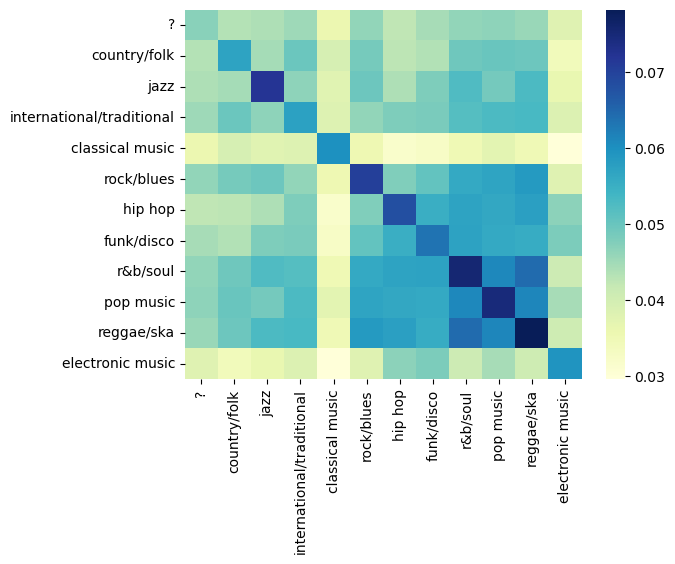

In [71]:
# !pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

similarity_df = pd.DataFrame(class_similarity)
sns.heatmap(similarity_df, cmap='YlGnBu')
plt.show()

In [72]:
import random
data = [(cap, lab) for cap, lab in zip(captions, labels)]
data[:10]
labeled_data = [(cap, lab) for cap, lab in zip(captions, labels) if lab != '?']
unlabeled_data = [(cap, lab) for cap, lab in zip(captions, labels) if lab == '?']

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=2, max_df=.98, ngram_range=(1,2))
cap_tfidf = tfidf.fit_transform(captions)
print ('features', tfidf.get_feature_names_out())
print(len(tfidf.get_feature_names_out()))
print ('stop words', tfidf.get_stop_words())



features ['aboriginal' 'abruptly' 'abruptly pause' ... 'zitar along' 'zither'
 'zumba']
17265
stop words None


# Classical Machine learning methods

Random Forest, SGD (Log loss) produced the best results

I've built pipelines for some other methods of classification like xgb and adaboost, you can use them as you see fit.

## Self-Training:

Used the self-training for semi-supervised learning. Not much change as only about 100 added data points

I've set up a few different sklearn pipelines below to preprocess and model the data. We can grid search for the best hyperparameters below as well.

In [74]:
from sklearn.base import TransformerMixin
class SMOTETransformer(TransformerMixin):
    def __init__(self, random_state=None):
        self.random_state = random_state
        self.smote = SMOTE(random_state=self.random_state)

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        X_resampled, y_resampled = self.smote.fit_resample(X)
        return X_resampled, y_resampled

In [75]:
#!pip install gensim
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin

class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1, workers=1):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None

    def fit(self, X, y=None):
        sentences = [s.split() for s in X]
        self.model = Word2Vec(sentences, vector_size=self.vector_size, window=self.window,
                              min_count=self.min_count, workers=self.workers)
        return self

    def transform(self, X):
        X_emb = []
        for s in X:
            emb = []
            for w in s.split():
                if w in self.model.wv.key_to_index:
                    emb.append(self.model.wv.get_vector(w))
            if len(emb) > 0:
                X_emb.append(np.mean(emb, axis=0))
            else:
                X_emb.append(np.zeros(self.size))
        return np.array(X_emb)

In [76]:
# !pip install -q imblearn
# !pip install -q xgboost
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import SGDClassifier
# from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
# from scikeras.wrappers import KerasClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import log_loss
from gensim.models import Doc2Vec, Word2Vec

# Parameters
ada_parameters= dict()
sgd_params = dict(loss="log_loss", early_stopping=True, alpha = 1e-4)
vectorizer_params = dict(ngram_range=(1, 2), stop_words='english',sublinear_tf=True,
                         max_df = 0.7, min_df=4, max_features= 5000)
w2v_params = dict(vector_size=10, window=5, min_count=1, workers=4)

rf_params = dict(max_depth=100,n_estimators=100,bootstrap =True)
xg_params = dict(max_depth=3, n_estimators=100, learning_rate=0.1, objective='multi:softmax', num_class=10)

ada_params= dict(estimator=SGDClassifier(**sgd_params))

# Supervised Pipeline
w2v_pipeline = Pipeline(
[
        ('word2vec', Word2VecTransformer(**w2v_params)),
        ('resample', SMOTE()),
#        ('to_dense', FunctionTransformer(lambda x: x.toarray())),
        ("clf", SGDClassifier(**sgd_params)),
        
    ]

)
sgd_pipeline = Pipeline(
    [
        ('tfidf', TfidfVectorizer(**vectorizer_params)),
        ('resample', SMOTE()),
#        ('to_dense', FunctionTransformer(lambda x: x.toarray())),
        ("clf", SGDClassifier(**sgd_params)),
        
    ]
)

rf_pipeline = Pipeline(
    [
    ('tfidf', TfidfVectorizer(**vectorizer_params)),
    ('resample', SMOTE()), 
    ("clf", RandomForestClassifier(**rf_params)),    
    ]
)

nb_pipeline = Pipeline(
    [
    ('tfidf', TfidfVectorizer(**vectorizer_params)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray())),
    ('resample', SMOTE()),
    ("clf", MultinomialNB())
    ]
)

xgb_pipeline = Pipeline(
    [
        ('tfidf', TfidfVectorizer(**vectorizer_params)),
        ('resample', SMOTE()), 
        ("clf", xgb.XGBClassifier(**xg_params))     
    ]

)

ada_pipeline = Pipeline(
    [
        ('tfidf', TfidfVectorizer(**vectorizer_params)),
        ('resample', SMOTE()), 
        ("clf", AdaBoostClassifier(**ada_params))   
    ]
)
bag_pipeline = Pipeline(
    [
        ('tfidf', TfidfVectorizer(**vectorizer_params)),
        ('resample', SMOTE()), 
        ("clf", BaggingClassifier(estimator=SGDClassifier(**sgd_params)))   
    ]
)

# SelfTraining Pipeline
st_pipeline = Pipeline(
    [
        ('tfidf', TfidfVectorizer(**vectorizer_params)),
        ('resample', SMOTE()),
        ("clf", SelfTrainingClassifier(SGDClassifier(**sgd_params), verbose=True, threshold=0.7)),
    ]
)



In [77]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
X, y = zip(*data)
X_lab, y_lab = zip(*labeled_data)
X_no_lab, y_no_lab= zip(*unlabeled_data)

y_no_lab_le = [-1 for y in y_no_lab]

X_train_lab, X_test, y_train_lab, y_test = train_test_split(X_lab, y_lab, test_size=0.2, random_state=42)

X_train = X_train_lab.copy()
print(len(X_train))
print(len(X_test))
print(len(X_no_lab))
X_train= np.append(X_train, X_no_lab)
print(X_train.size)
y_train = y_train_lab.copy()
y_train= np.append(y_train,y_no_lab_le)


1761
441
3319
5080


### Grid Search

The block below lets us grid search for optimum parameters for our classifier. It uses 5-fold cross validation to provide an estimate of the classifier's score on the test data. You can change the `parameters` dict to set new parameters for the search. 

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
parameters = {
    'tfidf__max_df': [0.75,0.7, 0.65],
    'tfidf__max_features': [3000, 4000, 5000,5500],
    'tfidf__min_df': [1,2,3,4,5]
}

random_search = RandomizedSearchCV(
    estimator=sgd_pipeline,
    param_distributions=parameters,
    n_iter=100,
    random_state=0,
    n_jobs=2,
    verbose=1,
)
grid_search = GridSearchCV(
    sgd_pipeline,
    parameters,
    verbose=1
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameters)

from time import time

t0 = time()
grid_search.fit(X_train_lab, y_train_lab)
print(f"Done in {time() - t0:.3f}s")

print("Best parameters combination found:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")
    
test_accuracy = grid_search.score(X_test, y_test)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {grid_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")


Performing grid search...
Hyperparameters to be evaluated:
{'tfidf__max_df': [0.75, 0.7, 0.65],
 'tfidf__max_features': [3000, 4000, 5000, 5500],
 'tfidf__min_df': [1, 2, 3, 4, 5]}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


KeyboardInterrupt: 

In [78]:
def eval_and_print_metrics(clf, X_train, y_train, X_test, y_test):
    print("Number of training samples:", len(X_train))
    print("Unlabeled samples in training set:", sum(1 for x in y_train if x == -1))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(
        "Micro-averaged F1 score on test set: %0.3f"
        % f1_score(y_test, y_pred, average="micro")
    )
    print("-" * 10)
    print()
    return f1_score(y_test, y_pred, average="micro")


In [ ]:
    """
    Testing to see if self training will help by masking part of the labelled data
    """
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import train_test_split
    
    print("Supervised SGDClassifier on 100% of the data:")
    eval_and_print_metrics(sgd_pipeline, X_train, y_train, X_test, y_test)

    # select a mask of 20% of the train dataset
    y_mask = np.random.rand(len(y_train)) < 0.2
    
    # X_20 and y_20 are the subset of the train dataset indicated by the mask
    X_20, y_20 = map(
        list, zip(*((x, y) for x, y, m in zip(X_train_lab, y_train_lab, y_mask) if m))
    )
    print("Supervised SGDClassifier on 20% of the training data:")
    eval_and_print_metrics(sgd_pipeline, X_20, y_20, X_test, y_test)

    # set the non-masked subset to be unlabeled
    for (i, in_mask) in zip(range(len(y_train)), y_mask):
        if not in_mask:
            y_train[i] = -1
#     y_train[~y_mask] = -1
    print("SelfTrainingClassifier on 20% of the training data (rest is unlabeled):")
    eval_and_print_metrics(st_pipeline, X_train, y_train, X_test, y_test)
    
    
    

### Experiments
The code below is what I ran for the experiments to get the final accuracy scores for each classifier. I ran each 30 times to account for stochasticity.

In [54]:
scores = np.array([])
f1_scores = np.array([])
for _ in range(30):
    sgd_pipeline.fit(X_train_lab, y_train_lab)
    scores =np.append(scores, sgd_pipeline.score(X_test, y_test))
    f1_scores = np.append(f1_scores, eval_and_print_metrics(sgd_pipeline,X_train_lab, y_train_lab,X_test, y_test))
print ('avg accuracy:', np.mean(scores))
print ('avg f1:', np.mean(f1_scores))

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.540
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.551
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.553
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.542
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.558
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.546
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.542
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.540
----------



In [55]:
scores = np.array([])
f1_scores = np.array([])
for _ in range(30):
    rf_pipeline.fit(X_train_lab, y_train_lab)
    scores =np.append(scores, rf_pipeline.score(X_test, y_test))
    f1_scores = np.append(f1_scores, eval_and_print_metrics(rf_pipeline,X_train_lab, y_train_lab,X_test, y_test))
print ('avg accuracy:', np.mean(scores))
print ('avg f1:', np.mean(f1_scores))

/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.515
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.553
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.515
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.526
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.537
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.522
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.537
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.551
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.531
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.517
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.517
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.519
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.540
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.540
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.522
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.522
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.535
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.526
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.524
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.517
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.522
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.524
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.544
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.519
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.524
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.544
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.517
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.506
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.528
----------



/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Number of training samples: 1761
Unlabeled samples in training set: 0


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Micro-averaged F1 score on test set: 0.528
----------

avg accuracy: 0.5242630385487528
avg f1: 0.5273620559334845


In [56]:
scores = np.array([])
f1_scores = np.array([])
for _ in range(30):
    nb_pipeline.fit(X_train_lab, y_train_lab)
    scores =np.append(scores, nb_pipeline.score(X_test, y_test))
    f1_scores = np.append(f1_scores, eval_and_print_metrics(nb_pipeline,X_train_lab, y_train_lab,X_test, y_test))
print ('avg accuracy:', np.mean(scores))
print ('avg f1:', np.mean(f1_scores))

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.490
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.467
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.476
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.478
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.481
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.485
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.481
----------

Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.476
----------



In [86]:
# Need to encode labels for ST pipeline to work. I'm leaving it here since i did not notice a signifigant
# improvement over the supervised methods.

# # Create a label encoder object. this will help us with plotting later
# le = LabelEncoder()
# # Convert the string labels to numeric labels
# y_lab = le.fit_transform(y_lab)
# y_train_st =  y_lab + [-1 for y in y_no_lab]
# X_train_st = X_train + X_no_lab
st_pipeline.fit(X_train_st, y_train_st)
st_pipeline.score(X_test, y_test)

ValueError: y has dtype string. If you wish to predict on string targets, use dtype object, and use -1 as the label for unlabeled samples.

In [87]:
eval_and_print_metrics(nb_pipeline,X_train_lab, y_train_lab,X_test, y_test)
nb_pipeline.fit(X_train_lab, y_train_lab)
nb_pipeline.score(X_test, y_test)


Number of training samples: 1761
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.472
----------



0.46938775510204084

In [88]:
rf_pipeline.fit(X_train_lab
                , y_train_lab)
rf_pipeline.score(X_test, y_test)


/home/ajb46717/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.5238095238095238

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(cls, X_train, y_train, X_test, y_test):
    le = LabelEncoder()
    le.fit_transform(y_train)
    # fit the pipeline to the training data
    cls.fit(X_train, y_train)

    # make predictions on the validation data
    y_pred = cls.predict(X_test)
    y_test = y_test
    y_pred = y_pred
    # compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # plot the confusion matrix using seaborn
    sns.heatmap(cm, annot=True, cmap="Blues",
                xticklabels= le.inverse_transform(range(11)),
                yticklabels= le.inverse_transform(range(11)),
               )
    plt.savefig("confusion_matrix.png",bbox_inches='tight')

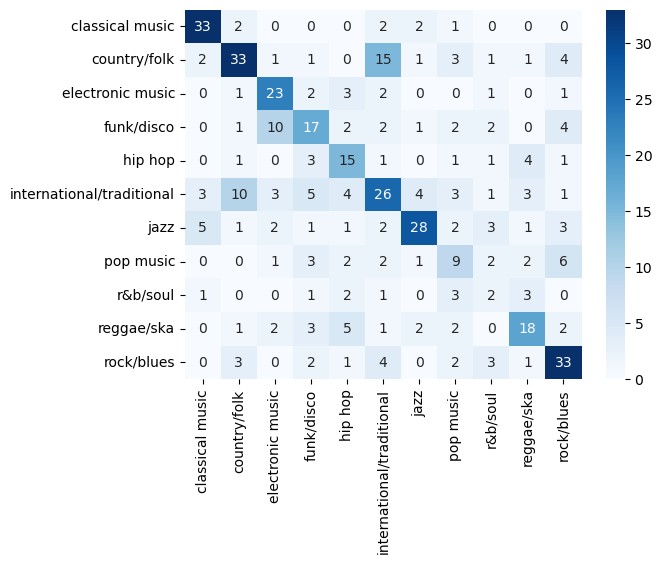

In [80]:
plot_confusion_matrix(sgd_pipeline, X_train_lab, y_train_lab, X_test, y_test)

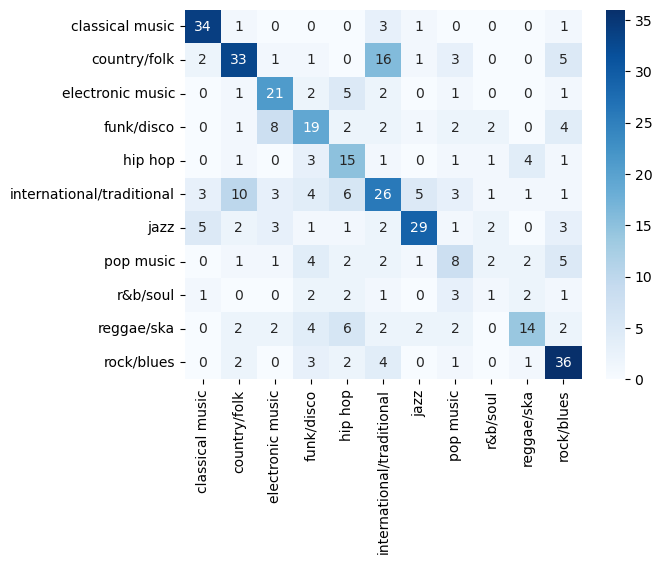

In [81]:
plot_confusion_matrix(sgd_pipeline, X_train_lab, y_train_lab, X_test, y_test)

## Keywords per class

Here is code to print the most informative key-terms per class. We can also visualize the impact each term from out vocabulary had on its class to see which term had the most information.

top 5 keywords per class:


,classical music,country/folk,electronic music,funk/disco,hip hop,international/traditional,jazz,pop music,r&b/soul,reggae/ska,rock/blues
0,classical,melody,sound,funky,male,percussion,jazz,female,groovy,male,guitar
1,piece,acoustic guitar,synth,groovy,voice,instrument,piano,singing,piano,bass,rock
2,live,country,electronic,beat,male vocal,recording,solo,pop,acoustic,reggae,electric guitar
3,audio,folk,kick,bass,hit,latin,fast,bass,bass line,electric,electric
4,emotional,acoustic,instrumental,melody,rapping,background,jazz song,live,punchy,drum,drumming
5,string,guitar,techno,synth,female,male,saxophone,vocal,guitar,male voice,instrumental
6,performance,singing,high,rhythm,synth,traditional,chord,pop music,emotional,singing,lead
7,classical music,folk music,synthesiser,harmony,medium,flute,trumpet,voice singing,harmony,percussion,blue
8,mellow,song played,club,bass guitar,digital,used,jazzy,crowd,guitar playing,male vocal,guitar playing
9,passionate,male vocal,exciting,club,tempo medium,dance,passionate,voice,simple,groovy,energetic


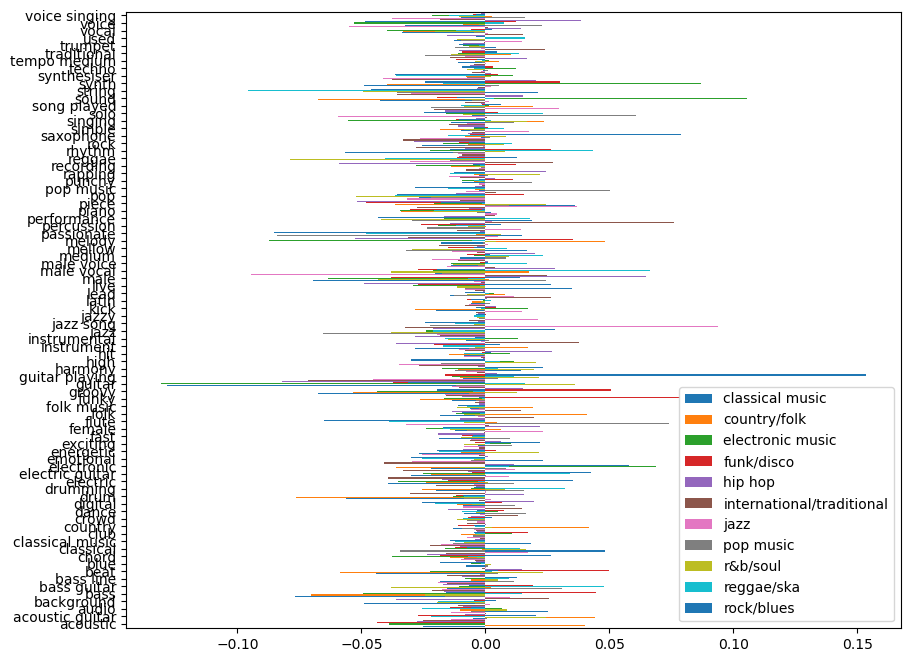

In [87]:
    from pprint import pprint
    # learned coefficients weighted by frequency of appearance
    clf = sgd_pipeline['clf']
    tfidf = sgd_pipeline['tfidf']
    target_names = sorted(caps_df_labeled.audioset_positive_labels.unique())
    feature_names = tfidf.get_feature_names_out()

    average_feature_effects = clf.coef_ * np.asarray(tfidf.transform(X_train_lab).mean(axis=0)).ravel()
    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-10:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")

    display(top)
    top.to_csv('keywords10.csv', index=True)


In [360]:
from sklearn.manifold import TSNE
tsne_model = TSNE(perplexity=15, n_components=2, init='random', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(cap_tfidf.toarray())


new_values[:20]


array([[-23.383522  ,  27.820858  ],
       [-69.72106   ,  10.312509  ],
       [-38.11259   ,  33.823322  ],
       [ 11.289403  ,  15.771488  ],
       [-24.893492  ,  38.45154   ],
       [-35.598797  ,  41.877235  ],
       [ 59.512146  , -14.290528  ],
       [  2.8945432 , -60.69715   ],
       [ 38.026867  ,  37.036934  ],
       [-71.769455  ,   7.2680955 ],
       [ 22.624449  ,  63.244473  ],
       [ 69.08972   ,   3.3141923 ],
       [-29.089935  , -47.45137   ],
       [-16.561012  , -32.97098   ],
       [ -2.0934067 , -42.22309   ],
       [  2.3110447 , -50.370087  ],
       [  0.29310092, -37.79989   ],
       [ 36.507496  ,  60.354557  ],
       [-17.700695  , -42.02886   ],
       [-21.954527  ,  32.930798  ]], dtype=float32)

In [361]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
def plot_values(values):
    x = []
    y = []

    #get the x and y values 
    for value in values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16)) 

    for i in range(200):
        plt.scatter(x[i],y[i])
        plt.annotate(text='',
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt

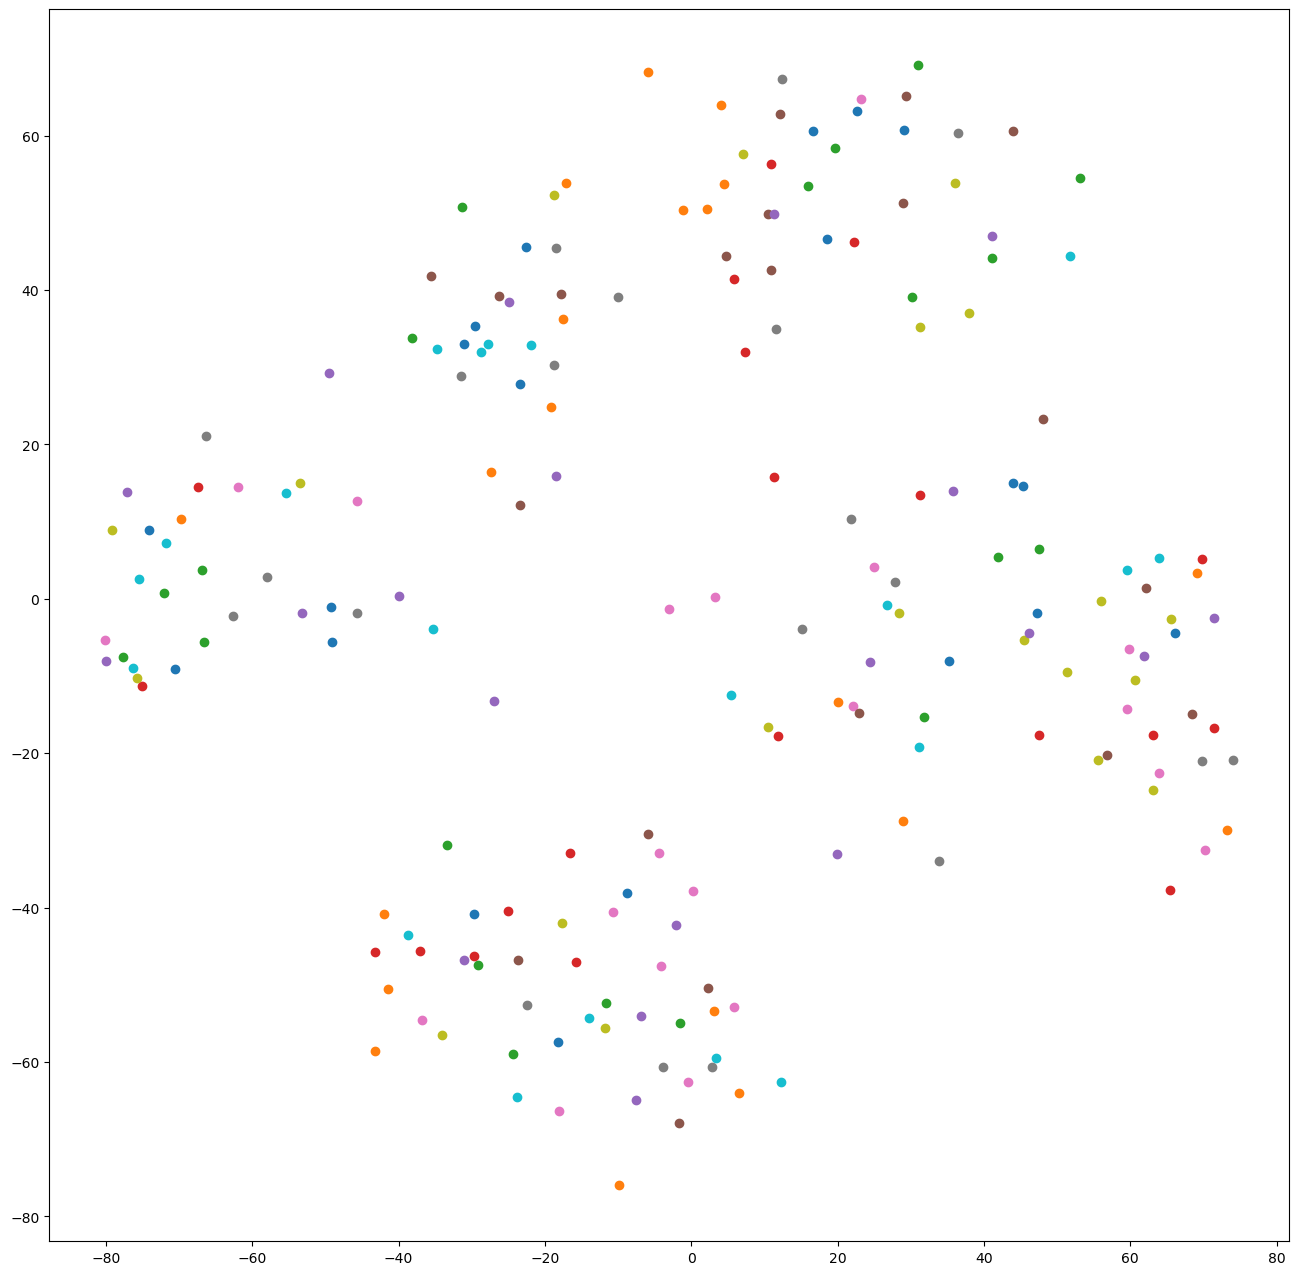

In [362]:
plot_values(new_values)
